In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import datetime
import random
from scipy import stats
import math
import nbimporter
from Modelling_utils import custom_distance,custom_distance_exp,get_xCCDF,find_opt_params,funcD,funcD_noC,get_results_PL_exp
import seaborn as sns

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
pd.options.display.max_rows = 4000

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

## UK Data reading

In [4]:
# UK data reading
# Note: no transport mode in the UK dataset, just use the sampled_data1
df_UK=pd.read_csv('data/UK_data.csv',usecols=["frequency", "distance"])
print(df_UK.head(2))
# extend the column distance according the column frequency
expanded_values = np.repeat(df_UK['distance'], df_UK['frequency'])
df_vec = pd.Series(expanded_values)
print('UK initial info:',len(expanded_values),", min trip --",df_vec.min(),", max trip --",df_vec.max())

min_distance=100
max_distance=900
maxdistance=900

#settings of parameters for UK ---Used for our model
eps_range=np.arange(1.5,3.21,0.1)
p_range=np.arange(0.2, 0.91, 0.05)
alp_range=np.arange(1.4,2.91,0.1)

# settings of parameters for modelling Power law with dynamic truncation
# eps_range=[1]
# p_range=[0]
# alp_range=np.arange(1.1,2.51,0.05)   


# SampleSize: number of samples for generating the trips
sampleSize=50000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# create an array of all parameter combinations to consider
# error is initialized to 0 and will be replaced later on
err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list
print("UK dataset size used: ",len(df_vec))


   frequency  distance
0          4    107.26
1          2    182.62
UK initial info: 1001069 , min trip -- 100.0 , max trip -- 1140.55
UK dataset size used:  1000717


## Model Training and Storage

In [5]:
# get the max range of trip length in the error calculation
max_d=get_xCCDF(df_vec, y_value=1e-3)
print('The max range of trip length in the error calculation', max_d)
#the number of sampling points in error calculation
num=1000

The max range of trip length in the error calculation 868.7500000000002


### Our model & Power law with dynamic truncation

In [ ]:
%%time
# Call the function to start the process
result = find_opt_params(combinable, sampleSize, min_distance, maxdistance, df_vec,max_d,num)
df_com=pd.DataFrame(result)
com=df_com.values

# The lowest error and corresponding parameters to get the optimal error
idx_best=com[:,3].argmin() #error

# the results contain the value of eps,p, alpha errors and list of simulated trip length
opt_modelling=pd.DataFrame(result[idx_best])
# opt_modelling.to_pickle(res+'Optimal results of LR Modelling in UK data.pkl')
# opt_modelling.to_pickle(res+'Optimal results of Power law with dynamic truncation for LR Modelling in UK data.pkl')

### Power law with exponential truncation

In [20]:
# Settings for UK
alphas=np.arange(1.01, 1.091,0.01) 
gammas=np.arange(200, 1201,20)
Ds=np.arange(100,2001,1)

In [23]:
%%time
opt_PLE_results=get_results_PL_exp(alphas,gammas,Ds,df_vec,max_d,num)
opt_PLE_results.to_pickle(res+"Optimal power-law with exponential truncation in UK.pkl")

CPU times: user 4min 10s, sys: 6.61 s, total: 4min 17s
Wall time: 4min 17s


# Plotting

In [18]:
'''CCDF plots for UK

Input:
    max_d: the max range of trip length in error calculation
    num: number of sampling points for error calculation 
'''
def ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d):
    fig, ax = plt.subplots(figsize=(3.54*1.5,2.83*1.5))
    colors=['#1f77b4','red','#2ca02c']
    linestyles=['solid','dashdot','dotted']
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
        ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the optimal results for powerlaw with exponential truncation
    Fd=[0]*len(Ds)
    for idx,d in enumerate(Ds):
        for i in Ds[Ds>=d]:
            Fd[idx]+=funcD(C,i,alpha,gamma)
    ax.plot(Ds,Fd,label='Power-law [E]',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.6,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    # leg = ax.legend(title='UK Long Distance',loc='lower left',alignment='left',framealpha=0.2)
    
    # leg.get_title().set_fontsize('15')
    
    # plt.yscale("log")
    # plt.xscale("log")
    # plt.ylim(bottom=1e-03) 
    plt.xlim(right=1e+3)  

    #------- plot the sub zoom plots
   
    # plt.xlim(right=300)  
    # plt.xlim(left=180)
    # plt.ylim(top=0.62)
    # plt.ylim(bottom=0.18)
    # ax.set_xticks([180, 200,300])
    
    # plt.xlim(right=500)  
    # plt.xlim(left=300)
    # plt.ylim(top=0.27)
    # plt.ylim(bottom=0.05)
    # ax.set_xticks([300,400,500])
    # # close the minor ticks
    # ax.xaxis.set_minor_locator(plt.NullLocator())
    
    #-------------
    plt.tight_layout()
    # plt.savefig(res+'CCDF_UK_4Lines_log.pdf', dpi=100, bbox_inches='tight')
    # plt.savefig(res+'CCDF_UK_4Lines_normal_sub1.pdf', dpi=100, bbox_inches='tight')
    # plt.savefig(res+'CCDF_UK_4Lines_normal_sub2.pdf', dpi=100, bbox_inches='tight')
    plt.savefig(res+'CCDF_UK_4Lines_normal.pdf', dpi=100, bbox_inches='tight')

In [7]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results"
'''
# UK dataset reading
df_vec=df_vec.copy() # Long distance in UK
print('UK data',len(df_vec),df_vec.max(),df_vec.min())

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR Modelling in UK data.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# power-law with dynamic truncation
opt_model_pl=pd.read_pickle(res+'Optimal results of Power law with dynamic truncation for LR Modelling in UK data.pkl')

optM_pl=np.array(opt_model_pl)
#Optimal result, which error is the lowest
eps_pl = optM_pl[0,0]
p_pl = optM_pl[1,0]
alp_pl = optM_pl[2,0]
dist_pl= optM_pl[4,0] #optimal trips list

print(df_vec.shape)
print("UK Our model: ",eps,p,alp,optM[3,0])
print("UK Power law [D]: ",eps_pl,p_pl,alp_pl,optM_pl[3,0])

UK data 1000717 899.7 100.0
(1000717,)
UK Our model:  2.9000000000000012 0.25 2.800000000000001 0.09527508562226594
UK Power law [D]:  1 0 2.1500000000000012 0.13298001448407434


CPU times: user 1.86 s, sys: 50.6 ms, total: 1.91 s
Wall time: 1.13 s


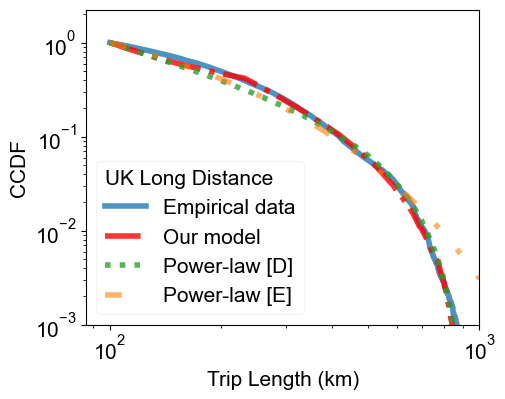

In [8]:
%%time
datalist=[df_vec,dist,dist_pl]
labels=['Empirical data','Our model','Power-law [D]']

# Reading the stored optimal power law with exponential truncation fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal power-law with exponential truncation in UK.pkl')
#optimal alpha and gamma
alpha=opt_trunc.alpha
gamma=opt_trunc.gamma
C=opt_trunc.C
Ds = np.arange(100,2001,1) #distance trips setted

# log-log plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)

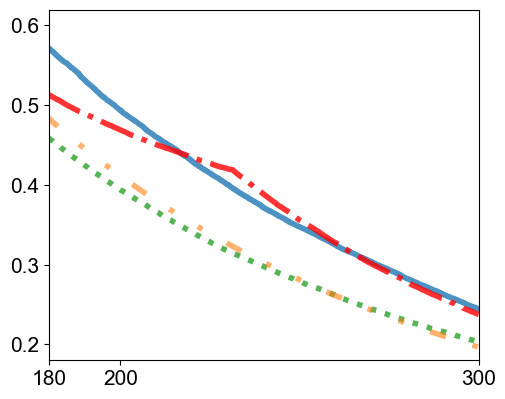

In [12]:
# normal sub1 plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)

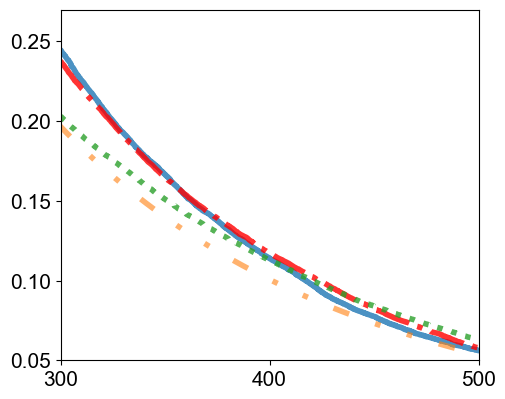

In [15]:
# normal sub2
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)

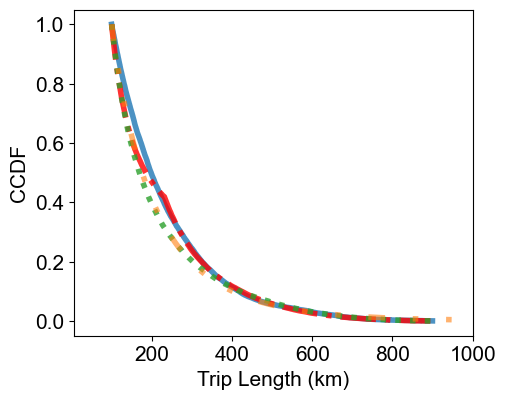

In [19]:
# normal plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)